In [33]:
import os
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
import torch_geometric.nn as geom_nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
CHECKPOINT_PATH = './saved_models/GNNs/'
AVAIL_GPUS = min(1, torch.xpu.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

# Setting the seed
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [35]:
#Create Checkpoint path
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [36]:
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import OneHotEncodeFeat
import torch
from torch_geometric.loader import DataLoader

NUM_NODE_FEATS = 28  # Number of node features in ZINC dataset
NUM_EDGE_FEATS = 4   # Number of edge features (bond types: 0, 1, 2, 3 where 0 is padding)
oneHotTransform = OneHotEncodeFeat(NUM_NODE_FEATS)

# Custom transform to ensure float type and process edge attributes
def ensure_float_transform(data):
    data = oneHotTransform(data)
    data.x = data.x.float()  # Ensure node features are float
    # Convert edge attributes to one-hot encoding for bond types
    data.edge_attr = torch.nn.functional.one_hot(data.edge_attr.long(), num_classes=NUM_EDGE_FEATS).float()
    return data

train_dataset = ZINC_Dataset.SMALL_TRAIN.load(transform=ensure_float_transform)
val_dataset = ZINC_Dataset.SMALL_VAL.load(transform=ensure_float_transform)
test_dataset = ZINC_Dataset.SMALL_TEST.load(transform=ensure_float_transform)

BATCH_SIZE = 32  # Define your batch size
graph_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
graph_val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)  # Additional loader for a larger datasets
graph_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")
print(f"Edge attribute shape after transform: {train_dataset[0].edge_attr.shape}")

Number of training graphs: 10000
Number of validation graphs: 1000
Number of test graphs: 1000
Edge attribute shape after transform: torch.Size([64, 4])


In [37]:
train_dataset[0]

Data(x=[29, 28], edge_index=[2, 64], edge_attr=[64, 4], y=[1])

In [39]:
# Examine edge attributes in detail
sample_graph = train_dataset[0]
print("Graph structure:")
print(f"Number of nodes: {sample_graph.x.shape[0]}")
print(f"Number of edges: {sample_graph.edge_index.shape[1]}")
print(f"Edge attributes shape: {sample_graph.edge_attr.shape}")
print(f"Edge attribute values: {sample_graph.edge_attr}")
print(f"Unique edge attribute values: {torch.unique(sample_graph.edge_attr)}")

# Check several graphs to understand edge attribute distribution
edge_attr_values = []
for i in range(10):
    edge_attr_values.extend(train_dataset[i].edge_attr.tolist())
# Convert lists to tuples to make them hashable for set operations
unique_edge_attrs = sorted(set(tuple(x) for x in edge_attr_values))
print(f"Overall unique edge attribute values: {unique_edge_attrs}")

Graph structure:
Number of nodes: 29
Number of edges: 64
Edge attributes shape: torch.Size([64, 4])
Edge attribute values: tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0.

In [40]:
# Verify edge attributes after transformation
sample_graph = train_dataset[0]
print("After transformation:")
print(f"Edge attributes shape: {sample_graph.edge_attr.shape}")
print(f"First few edge attributes:\n{sample_graph.edge_attr[:5]}")
print(f"Original edge attr values: {sample_graph.edge_attr.argmax(dim=1)[:10]}")

# Test with a batch
batch = next(iter(graph_train_loader))
print(f"\nBatch edge attributes shape: {batch.edge_attr.shape}")

After transformation:
Edge attributes shape: torch.Size([64, 4])
First few edge attributes:
tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
Original edge attr values: tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 2])

Batch edge attributes shape: torch.Size([1612, 4])


# Summary: Edge Attribute Integration for Molecular Bond Types

The notebook has been successfully modified to handle different edge types (single, double, triple bonds) in molecular graphs. Here are the key changes made:

## 1. Dataset Preprocessing
- **Edge attribute encoding**: Modified `ensure_float_transform()` to convert edge attributes to one-hot encoding
- **Bond type mapping**: Edge attributes are converted from categorical values (1, 2, 3) to one-hot vectors of size 4
- **Data verification**: Added cells to examine edge attribute structure and verify proper transformation

## 2. GNN Model Updates
- **Edge-aware layers**: Updated `GNNModel` to support layers that can use edge attributes:
  - **GAT/GATv2**: Support edge features through `edge_dim` parameter
  - **GINEConv**: Graph Isomorphism Network with Edge features
  - **Layer selection**: Automatic detection of which layers support edge attributes
- **Forward pass**: Modified to pass edge attributes through the network when supported

## 3. Architecture Changes
- **GraphGNNModel**: Updated to handle edge attributes in embeddings and forward pass
- **GraphLevelGNN**: Modified forward pass to extract and process edge attributes from batch data
- **Training function**: Added `edge_dim=NUM_EDGE_FEATS` parameter to model initialization

## 4. Edge Attribute Support by Layer Type
- ✅ **GAT/GATv2**: Native edge attribute support
- ✅ **GINEConv**: Designed specifically for edge features  
- ❌ **GCN/GraphConv/SAGE**: No edge attribute support (graceful fallback to node-only processing)

## 5. Bond Type Information
- **Single bonds**: Encoded as [0, 1, 0, 0]
- **Double bonds**: Encoded as [0, 0, 1, 0]  
- **Triple bonds**: Encoded as [0, 0, 0, 1]
- **Padding**: Encoded as [1, 0, 0, 0] (unused in practice)

## Benefits
- **Chemical accuracy**: Models can now distinguish between different bond types
- **Improved representations**: Edge features provide additional information about molecular structure
- **Flexibility**: Code automatically handles both edge-aware and edge-unaware GNN layers

In [41]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(x=[732, 28], edge_index=[2, 1570], edge_attr=[1570, 4], y=[32], batch=[732], ptr=[33])
Labels: tensor([ 1.9973,  0.6860,  0.7742,  0.1526, -1.3634, -0.6959, -0.5774, -1.8250,
         1.1568, -4.4950])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])


In [42]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        edge_dim=None,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            edge_dim: Dimension of edge features (for layers that support edge attributes)
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)

        """
        super().__init__()
        
        # Check if the layer supports edge attributes
        self.supports_edge_attr = layer_name in ["GAT", "GATv2", "GINEConv"]
        self.layer_name = layer_name

        layers = []
        in_channels, out_channels = c_in, c_hidden
        
        for l_idx in range(num_layers - 1):
            layer_kwargs = kwargs.copy()
            
            if layer_name == "GCN":
                gnn_layer = geom_nn.GCNConv(in_channels, out_channels, **layer_kwargs)
            elif layer_name == "GraphConv":
                gnn_layer = geom_nn.GraphConv(in_channels, out_channels, **layer_kwargs)
            elif layer_name == "GAT":
                if self.supports_edge_attr and edge_dim is not None:
                    layer_kwargs['edge_dim'] = edge_dim
                gnn_layer = geom_nn.GATConv(in_channels, out_channels, **layer_kwargs)
            elif layer_name == "SAGE":
                gnn_layer = geom_nn.SAGEConv(in_channels, out_channels, **layer_kwargs)
            elif layer_name == "GATv2":
                if self.supports_edge_attr and edge_dim is not None:
                    layer_kwargs['edge_dim'] = edge_dim
                gnn_layer = geom_nn.GATv2Conv(in_channels, out_channels, **layer_kwargs)
            elif layer_name == "GIN":
                # GIN requires a neural network as parameter
                nn_module = nn.Sequential(
                    nn.Linear(in_channels, out_channels),
                    nn.ReLU(),
                    nn.Linear(out_channels, out_channels)
                )
                gnn_layer = geom_nn.GINConv(nn_module, **layer_kwargs)
            elif layer_name == "GINEConv":
                # GINE requires a neural network and supports edge features
                nn_module = nn.Sequential(
                    nn.Linear(in_channels, out_channels),
                    nn.ReLU(),
                    nn.Linear(out_channels, out_channels)
                )
                if edge_dim is not None:
                    layer_kwargs['edge_dim'] = edge_dim
                gnn_layer = geom_nn.GINEConv(nn_module, **layer_kwargs)
            else:
                gnn_layer = geom_nn.GCNConv(in_channels, out_channels, **layer_kwargs)  # Default fallback
            
            layers += [
                gnn_layer,
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
            
        # Final layer
        final_kwargs = kwargs.copy()
        
        if layer_name == "GCN":
            final_layer = geom_nn.GCNConv(in_channels, c_out, **final_kwargs)
        elif layer_name == "GraphConv":
            final_layer = geom_nn.GraphConv(in_channels, c_out, **final_kwargs)
        elif layer_name == "GAT":
            if self.supports_edge_attr and edge_dim is not None:
                final_kwargs['edge_dim'] = edge_dim
            final_layer = geom_nn.GATConv(in_channels, c_out, **final_kwargs)
        elif layer_name == "SAGE":
            final_layer = geom_nn.SAGEConv(in_channels, c_out, **final_kwargs)
        elif layer_name == "GATv2":
            if self.supports_edge_attr and edge_dim is not None:
                final_kwargs['edge_dim'] = edge_dim
            final_layer = geom_nn.GATv2Conv(in_channels, c_out, **final_kwargs)
        elif layer_name == "GIN":
            nn_module = nn.Sequential(
                nn.Linear(in_channels, c_out),
                nn.ReLU(),
                nn.Linear(c_out, c_out)
            )
            final_layer = geom_nn.GINConv(nn_module, **final_kwargs)
        elif layer_name == "GINEConv":
            nn_module = nn.Sequential(
                nn.Linear(in_channels, c_out),
                nn.ReLU(),
                nn.Linear(c_out, c_out)
            )
            if edge_dim is not None:
                final_kwargs['edge_dim'] = edge_dim
            final_layer = geom_nn.GINEConv(nn_module, **final_kwargs)
        else:
            final_layer = geom_nn.GCNConv(in_channels, c_out, **final_kwargs)  # Default fallback
        
        layers.append(final_layer)
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index, edge_attr=None):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            edge_attr: Edge attributes (bond types, etc.)

        """
        # Ensure x is float type
        x = x.float()
        # Ensure edge_index is long type
        edge_index = edge_index.long()
        
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                if self.supports_edge_attr and edge_attr is not None:
                    x = layer(x, edge_index, edge_attr=edge_attr)
                else:
                    x = layer(x, edge_index)
            else:
                x = layer(x)
        return x


In [43]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """MLPModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network

        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """Forward.

        Args:
            x: Input features per node

        """
        return self.layers(x)

In [44]:
class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """GraphGNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of output features (usually number of classes)
            dp_rate_linear: Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs: Additional arguments for the GNNModel object

        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_hidden, **kwargs)  # Not our prediction output yet!
        self.head = nn.Sequential(nn.Dropout(dp_rate_linear), nn.Linear(c_hidden, c_out))

    def forward(self, x, edge_index, batch_idx, edge_attr=None):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node
            edge_attr: Edge attributes (bond types, etc.)

        """
        x = self.embeddings(x, edge_index, batch_idx, edge_attr)
        x = self.head(x)
        return x
    
    def embeddings(self, x, edge_index, batch_idx, edge_attr=None):
        """Get embeddings.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node
            edge_attr: Edge attributes (bond types, etc.)

        Returns:
            Embeddings of the nodes after GNN layers but before the head layer.

        """
        x = self.GNN(x, edge_index, edge_attr)
        x = geom_nn.global_mean_pool(x, batch_idx)
        return x

In [50]:
from typing import Literal
class GraphLevelGNN(pl.LightningModule):
    def __init__(self, loss: Literal['mse', 'mae'] = 'mae', **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        if loss == 'mae':
            self.loss_module = nn.L1Loss()
        elif loss == 'mse':
            self.loss_module = nn.MSELoss()
        else:
            raise ValueError(f"Unsupported loss type: {loss}")

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        edge_attr = getattr(data, 'edge_attr', None)  # Get edge attributes if available
        
        # Ensure correct data types
        x = x.float()
        edge_index = edge_index.long()
        batch_idx = batch_idx.long()
        if edge_attr is not None:
            edge_attr = edge_attr.float()
        
        x = self.model(x, edge_index, batch_idx, edge_attr)
        x = x.squeeze(dim=-1)

        loss = self.loss_module(x, data.y)
        return x, loss

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.0)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="train")[1]
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y, loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)
        mae = nn.L1Loss()(y, batch.y)
        self.log("val_mae", mae)
        return loss, mae

    def test_step(self, batch, batch_idx):
        y, loss = self.forward(batch, mode="test")
        self.log("test_loss", loss, prog_bar=True)
        mae = nn.L1Loss()(y, batch.y)   
        self.log("test_mae", mae, prog_bar=True)
        return {"test_loss": loss, "test_mae": mae}

In [ ]:
def train_graph_classifier(model_name, maxEpochs = 100, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH,
                            "GraphLevel" + model_name +
                            "_hidden_" + str(model_kwargs.get("c_hidden", 2)) +
                            "_loss_" + model_kwargs.get("loss", "mae") +
                            "_num_layers_" + str(model_kwargs.get("num_layers", 2)) +
                            "_layer_" + model_kwargs.get("layer_name", "GraphConv") +
                            "_dp_linear_" + str(model_kwargs.get("dp_rate_linear", 0.5)) +
                            "_dp_" + str(model_kwargs.get("dp_rate", 0.0)))
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
        accelerator="cpu",
        devices=AVAIL_GPUS,
        max_epochs=maxEpochs,
        enable_progress_bar=True,
    )
    trainer.logger._default_hp_metric = None

    pl.seed_everything(42)
    model = GraphLevelGNN(
        c_in=NUM_NODE_FEATS,
        c_out=1,
        edge_dim=NUM_EDGE_FEATS,  # Add edge dimension for bond types
        **model_kwargs,
    )
    trainer.fit(model, graph_train_loader, graph_val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, dataloaders=graph_train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=graph_val_loader, verbose=False)
    result = {"val": val_result[0]["test_loss"], "train": train_result[0]["test_loss"]}
    return model, result

In [58]:
model, result = train_graph_classifier(
    model_name="GraphConv_0", c_hidden=100, layer_name="GCN", num_layers=3, dp_rate_linear=0.5, dp_rate=0.0, maxEpochs=100, loss='mae'
)

Seed set to 42
GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
Seed set to 42

  | Name        | Type          | Params | Mode 
------------------------------------------------------
0 | model       | GraphGNNModel | 23.2 K | train
1 | loss_module | L1Loss        | 0      | train
------------------------------------------------------
23.2 K    Trainable params
0         Non-trainable params
23.2 K    Total params
0.093     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode

  | Name        | Type          | Params | Mode 
------------------------------------------------------
0 | model       | GraphGNNModel | 23.2 K | train
1 | loss_module | L1Loss        | 0      | train
------------------------------------------------------
23.2 K    Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

In [59]:
# model = GraphLevelGNN.load_from_checkpoint(
#     os.path.join(CHECKPOINT_PATH, "GraphLevelGraphConv_0_hidden_100_loss_mae_num_layers_2_layer_GAT_dp_linear_0.5_dp_0.0", "lightning_logs", "version_0", "checkpoints", "epoch=60-step=2440.ckpt"),
#     hparams_file=os.path.join(CHECKPOINT_PATH, "GraphLevelGraphConv_0_hidden_100_loss_mae_num_layers_2_layer_GAT_dp_linear_0.5_dp_0.0", "lightning_logs", "version_0", "hparams.yaml")
# )
# print(model)

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [69]:
#Compute and store the validation embeddings
@torch.no_grad()
def compute_embeddings(model, data_loader):
    embeddings = []
    for batch in data_loader:
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        edge_attr = getattr(batch, 'edge_attr', None)  # Get edge attributes if available
        x = model.model.embeddings(x, edge_index, batch_idx, edge_attr)
        embeddings.append(x)
    return torch.cat(embeddings, dim=0)
embeddings = compute_embeddings(model, graph_val_loader)
train_embeddings = compute_embeddings(model, graph_train_loader)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.078140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.939728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.939728
[t-SNE] KL divergence after 1000 iterations: 0.477847
[t-SNE] KL divergence after 1000 iterations: 0.477847


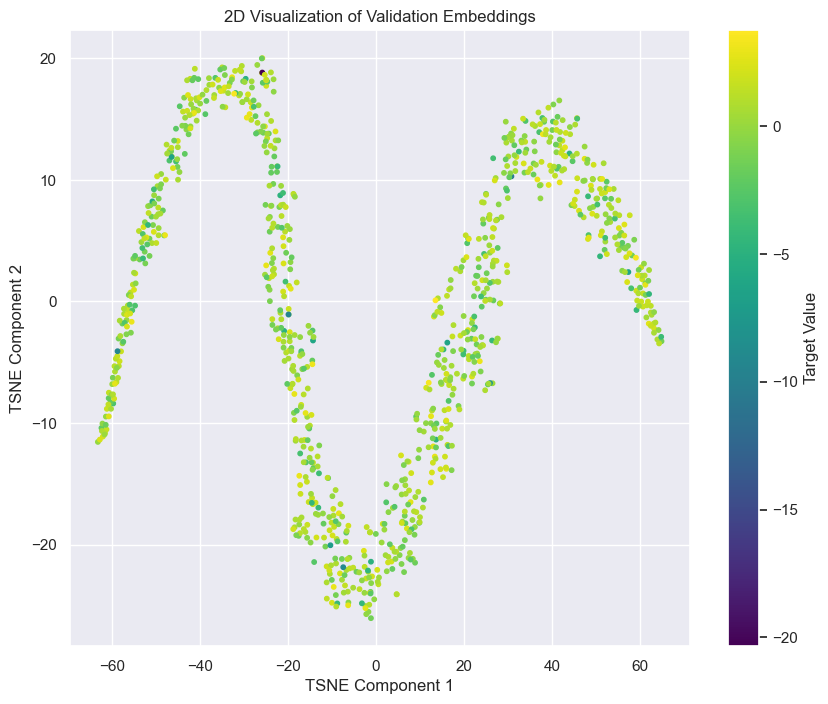

In [62]:
#Tsne on the validation embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, verbose=1)
val_embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())
#Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], c=val_dataset.y.cpu().numpy(), cmap='viridis', s=10)
plt.colorbar(label='Target Value')
plt.title('2D Visualization of Validation Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Thu Jun 26 18:48:27 2025 Construct fuzzy simplicial set
Thu Jun 26 18:48:28 2025 Finding Nearest Neighbors
Thu Jun 26 18:48:28 2025 Finished Nearest Neighbor Search
Thu Jun 26 18:48:28 2025 Construct embedding
Thu Jun 26 18:48:28 2025 Finding Nearest Neighbors
Thu Jun 26 18:48:28 2025 Finished Nearest Neighbor Search
Thu Jun 26 18:48:28 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jun 26 18:48:30 2025 Finished embedding
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jun 26 18:48:30 2025 Finished embedding


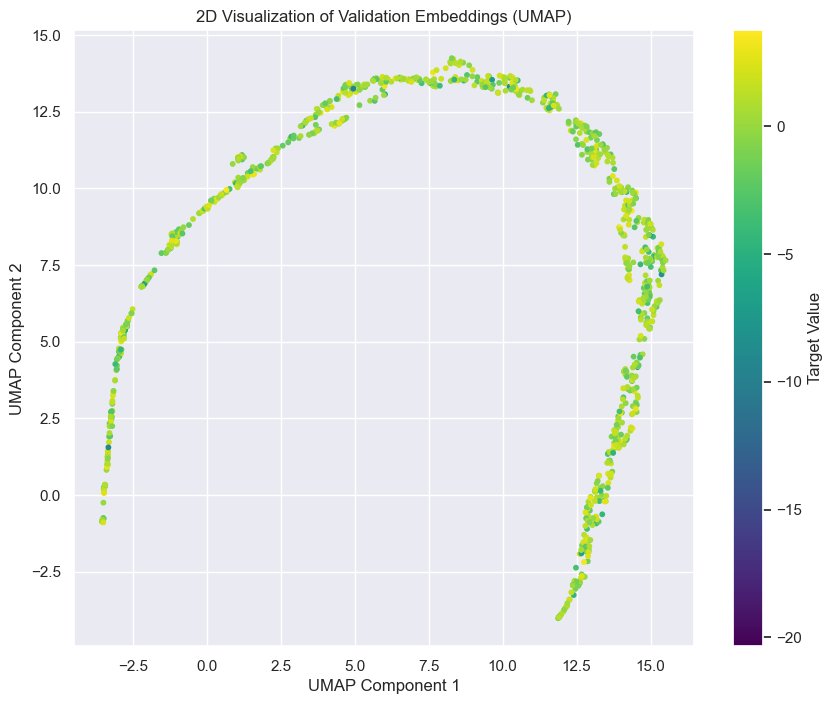

In [63]:
#Umap on the validation embeddings
import umap
umap_model = umap.UMAP(n_components=2, random_state=42, verbose=True)
val_embeddings_2d_umap = umap_model.fit_transform(embeddings.cpu().numpy())
#Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(val_embeddings_2d_umap[:, 0], val_embeddings_2d_umap[:, 1], c=val_dataset.y.cpu().numpy(), cmap='viridis', s=10)
plt.colorbar(label='Target Value')
plt.title('2D Visualization of Validation Embeddings (UMAP)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [64]:
#Compute validation predictions
@torch.no_grad()
def compute_predictions(model, data_loader):
    predictions = []
    for batch in data_loader:
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        edge_attr = getattr(batch, 'edge_attr', None)  # Get edge attributes if available
        preds = model.model(x, edge_index, batch_idx, edge_attr)
        predictions.append(preds)
    return torch.cat(predictions, dim=0)

predictions_train = compute_predictions(model, graph_train_loader)
predictions_val = compute_predictions(model, graph_val_loader)
predictions_train.shape, predictions_val.shape

(torch.Size([10000, 1]), torch.Size([1000, 1]))

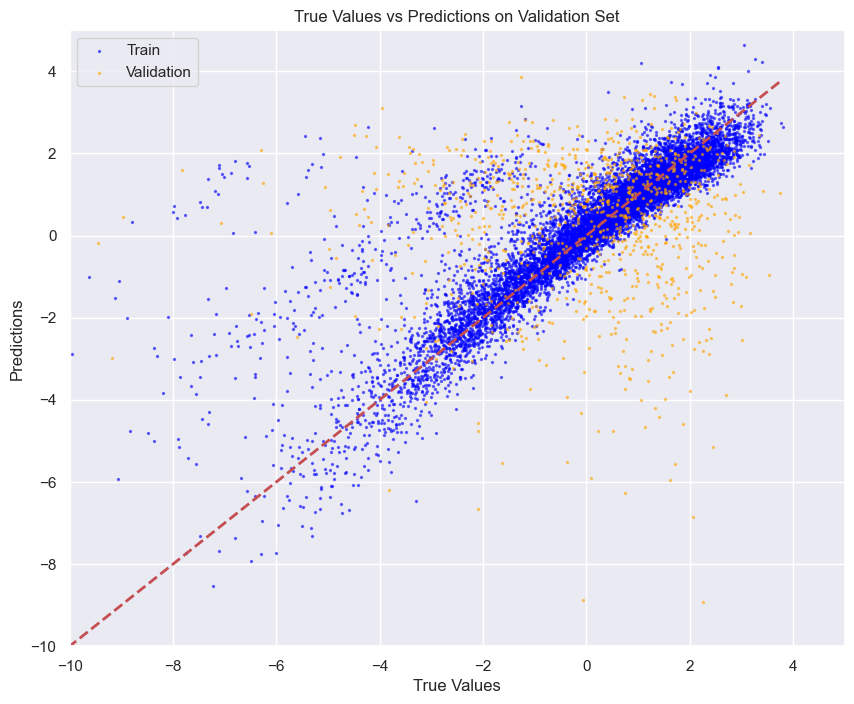

In [65]:
#Plot target vs prediction
plt.figure(figsize=(10, 8))
plt.scatter(train_dataset.y.cpu().numpy(), predictions_train.cpu().numpy(), alpha=0.5, color='blue', s=2, label='Train')
plt.scatter(val_dataset.y.cpu().numpy(), predictions_val.cpu().numpy(), alpha=0.5, color='orange', s=2, label='Validation')
plt.plot([val_dataset.y.min(), val_dataset.y.max()], [val_dataset.y.min(), val_dataset.y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions on Validation Set')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

[0]	validation_0-rmse:2.03618
[1]	validation_0-rmse:2.14627
[1]	validation_0-rmse:2.14627
[2]	validation_0-rmse:2.25696
[2]	validation_0-rmse:2.25696
[3]	validation_0-rmse:2.34994
[3]	validation_0-rmse:2.34994
[4]	validation_0-rmse:2.41936
[4]	validation_0-rmse:2.41936
[5]	validation_0-rmse:2.47593
[5]	validation_0-rmse:2.47593
[6]	validation_0-rmse:2.51519
[6]	validation_0-rmse:2.51519
[7]	validation_0-rmse:2.54965
[7]	validation_0-rmse:2.54965
[8]	validation_0-rmse:2.57259
[8]	validation_0-rmse:2.57259
[9]	validation_0-rmse:2.58858
[9]	validation_0-rmse:2.58858
[10]	validation_0-rmse:2.59794
[10]	validation_0-rmse:2.59794
[11]	validation_0-rmse:2.60888
[11]	validation_0-rmse:2.60888
[12]	validation_0-rmse:2.61642
[12]	validation_0-rmse:2.61642
[13]	validation_0-rmse:2.61996
[13]	validation_0-rmse:2.61996
[14]	validation_0-rmse:2.62214
[14]	validation_0-rmse:2.62214
[15]	validation_0-rmse:2.62381
[15]	validation_0-rmse:2.62381
[16]	validation_0-rmse:2.62450
[16]	validation_0-rmse:2.62

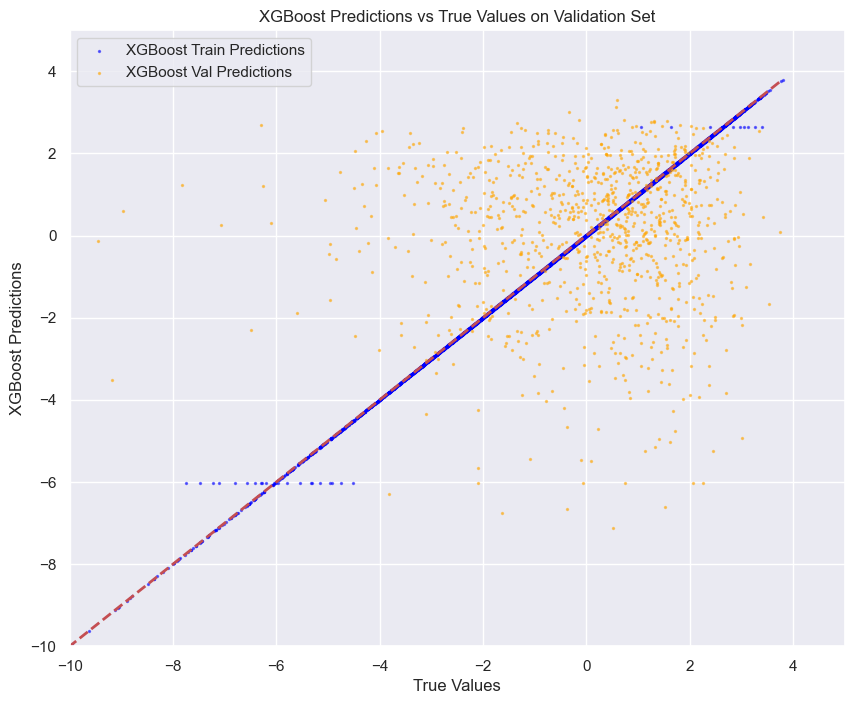

MAE for XGBoost on validation set: 1.9751


In [73]:
#Perform xgboost regression on the embeddings, objective mean absolute error
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    n_jobs=-1,
    max_depth=10,
)
xgb_model.fit(
    train_embeddings.cpu().numpy(),
    train_dataset.y.cpu().numpy(),
    eval_set=[(embeddings.cpu().numpy(), val_dataset.y.cpu().numpy())],
    verbose=True,
)
# Evaluate the XGBoost model
xgb_predictions = xgb_model.predict(embeddings.cpu().numpy())
xgb_train_predictions = xgb_model.predict(train_embeddings.cpu().numpy())
# Plot XGBoost predictions vs true values
plt.figure(figsize=(10, 8))
plt.scatter(train_dataset.y.cpu().numpy(), xgb_train_predictions, alpha=0.5, color='blue', s=2, label='XGBoost Train Predictions')
plt.scatter(val_dataset.y.cpu().numpy(), xgb_predictions, alpha=0.5, color='orange', s=2, label='XGBoost Val Predictions')
plt.plot([val_dataset.y.min(), val_dataset.y.max()], [val_dataset.y.min(),
    val_dataset.y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('XGBoost Predictions')
plt.title('XGBoost Predictions vs True Values on Validation Set')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

#Print MAE for XGBoost
from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(val_dataset.y.cpu().numpy(), xgb_predictions)
print(f"MAE for XGBoost on validation set: {mae_xgb:.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished
[Parallel(n_jo

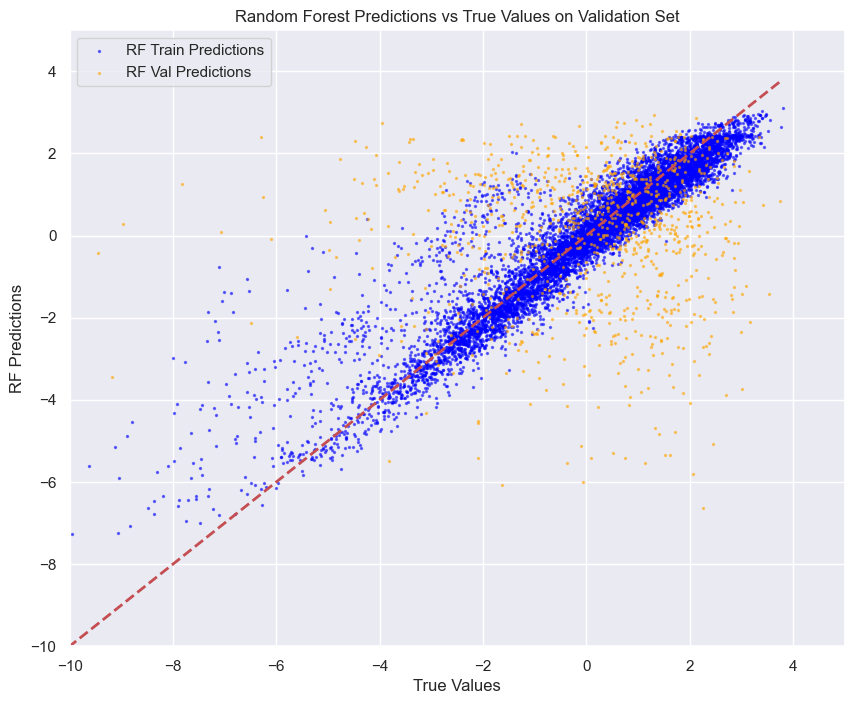

MAE for Random Forest on validation set: 1.9254


In [77]:
#Train Random forset regressor on the embeddings
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=1000,
    n_jobs=-1,
    max_depth=10,
    random_state=42,
    verbose=1,
)
rf_model.fit(
    train_embeddings.cpu().numpy(),
    train_dataset.y.cpu().numpy(),
)

# Evaluate the Random Forest model
rf_predictions = rf_model.predict(embeddings.cpu().numpy())
rf_train_predictions = rf_model.predict(train_embeddings.cpu().numpy())
# Plot Random Forest predictions vs true values
plt.figure(figsize=(10, 8))
plt.scatter(train_dataset.y.cpu().numpy(), rf_train_predictions, alpha=0.5, color='blue', s=2, label='RF Train Predictions')    
plt.scatter(val_dataset.y.cpu().numpy(), rf_predictions, alpha=0.5, color='orange', s=2, label='RF Val Predictions')
plt.plot([val_dataset.y.min(), val_dataset.y.max()], [val_dataset.y.min(), val_dataset.y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('RF Predictions')
plt.title('Random Forest Predictions vs True Values on Validation Set')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

#Print MAE for Random Forest
mae_rf = mean_absolute_error(val_dataset.y.cpu().numpy(), rf_predictions)
print(f"MAE for Random Forest on validation set: {mae_rf:.4f}")

Shape of random walk PE: torch.Size([10000, 19])
Shape of target values: torch.Size([10000, 1])


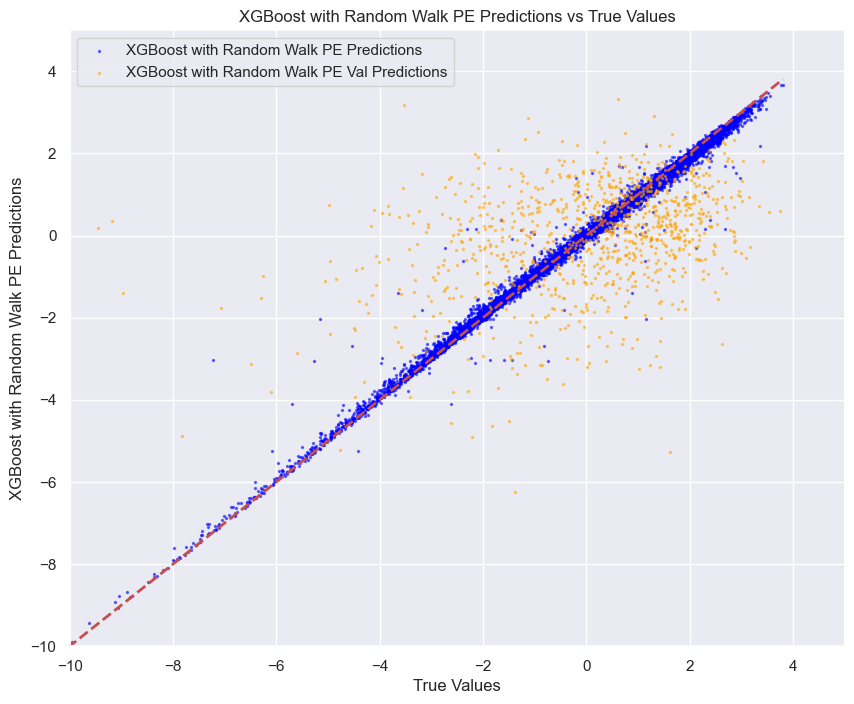

MAE for XGBoost with Random Walk PE on validation set: 1.4739


In [115]:
from torch_geometric.transforms import AddRandomWalkPE
transform = AddRandomWalkPE(walk_length=20)

xs = [transform(g).random_walk_pe[:, 1:].sum(dim=0) for g in train_dataset]
ys = [g.y for g in train_dataset]
x_vals = [transform(g).random_walk_pe[:, 1:].sum(dim=0) for g in val_dataset]
y_vals = [g.y for g in val_dataset]

xs = torch.stack(xs)
ys = torch.stack(ys)
x_vals = torch.stack(x_vals)
y_vals = torch.stack(y_vals)

print(f"Shape of random walk PE: {xs.shape}")
print(f"Shape of target values: {ys.shape}")
#xgboost
xgb_model_pe = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    n_jobs=-1,
)
xgb_model_pe.fit(
    xs.cpu().numpy(),
    ys.cpu().numpy(),
    verbose=True,
)
# Evaluate the XGBoost model with random walk PE
xgb_predictions_pe = xgb_model_pe.predict(xs.cpu().numpy())
xgb_val_predictions_pe = xgb_model_pe.predict(x_vals.cpu().numpy())

# Plot XGBoost predictions with random walk PE vs true values
plt.figure(figsize=(10, 8))
plt.scatter(ys.cpu().numpy(), xgb_predictions_pe, alpha=0.5,
            color='blue', s=2, label='XGBoost with Random Walk PE Predictions')
plt.scatter(y_vals.cpu().numpy(), xgb_val_predictions_pe, alpha=0.5,
            color='orange', s=2, label='XGBoost with Random Walk PE Val Predictions')
plt.plot([ys.min(), ys.max()], [ys.min(), ys.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('XGBoost with Random Walk PE Predictions')
plt.title('XGBoost with Random Walk PE Predictions vs True Values')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

#Compute MAE for XGBoost with random walk PE
mae_xgb_pe = mean_absolute_error(y_vals.cpu().numpy(), xgb_val_predictions_pe)
print(f"MAE for XGBoost with Random Walk PE on validation set: {mae_xgb_pe:.4f}")

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | ela

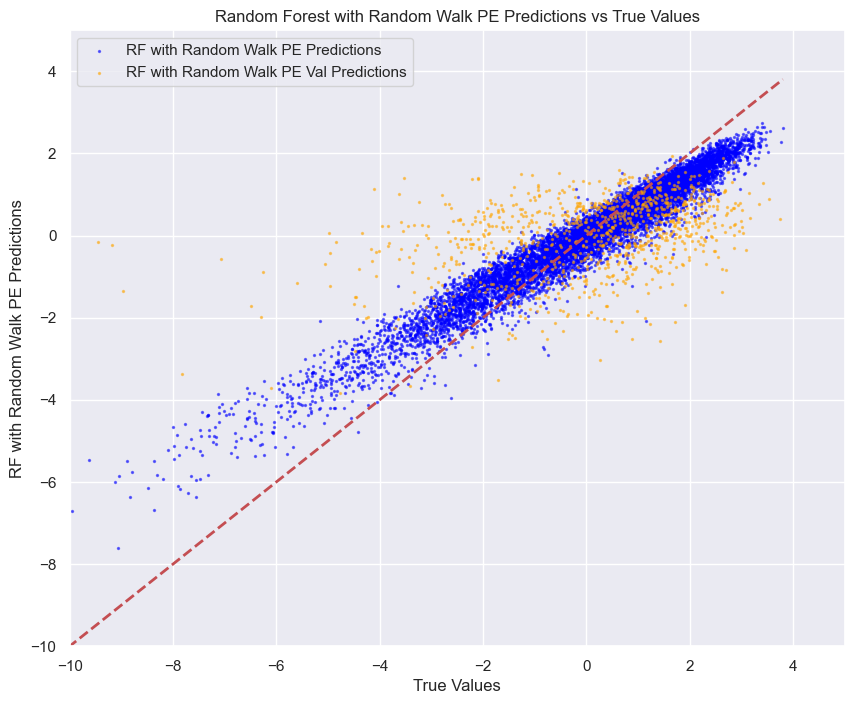

MAE for Random Forest with Random Walk PE on validation set: 1.3498


In [116]:
#Random forest with random walk PE
rf_model_pe = RandomForestRegressor(
    n_estimators=1000,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)
rf_model_pe.fit(
    xs.cpu().numpy(),
    ys.cpu().numpy(),
)
# Evaluate the Random Forest model with random walk PE
rf_predictions_pe = rf_model_pe.predict(xs.cpu().numpy())
rf_val_predictions_pe = rf_model_pe.predict(x_vals.cpu().numpy())
# Plot Random Forest predictions with random walk PE vs true values
plt.figure(figsize=(10, 8))
plt.scatter(ys.cpu().numpy(), rf_predictions_pe, alpha=0.5,
            color='blue', s=2, label='RF with Random Walk PE Predictions')
plt.scatter(y_vals.cpu().numpy(), rf_val_predictions_pe, alpha=0.5,
            color='orange', s=2, label='RF with Random Walk PE Val Predictions')
plt.plot([ys.min(), ys.max()], [ys.min(), ys.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('RF with Random Walk PE Predictions')
plt.title('Random Forest with Random Walk PE Predictions vs True Values')
plt.legend()
plt.xlim(-10, 5)
plt.ylim(-10, 5)
plt.show()

#Compute MAE for Random Forest with random walk PE
mae_rf_pe = mean_absolute_error(y_vals.cpu().numpy(), rf_val_predictions_pe)
print(f"MAE for Random Forest with Random Walk PE on validation set: {mae_rf_pe:.4f}")